## Stanley tracker

Stanley controller was used in the DARPA-challenge winning autonomous vehicle, back in the day. 
It is a non-linear controller, which explicitly takes into account **ref_theta** unlike pure pursuit. Because it was used for a car, a bicycle model is to be used for vehicular motion

Trackers are trying to minimize 2 types of errors

1. Positional error or cross-track error $x_e$

2. Heading error $\theta_e$

Tracker controls the steering as a function of these 2 errors

$\delta = \theta_e + \tan^{-1}\frac{kx_e}{v}$

The second term can be thought of as how quickly do we want the vehicle to compensate for the positional error relative to vehicle velocity


Snider has a nice/ concise summary of how it works in Sec 2.3 of his Phd thesis
https://www.ri.cmu.edu/pub_files/2009/2/Automatic_Steering_Methods_for_Autonomous_Automobile_Path_Tracking.pdf

There is a reference implementation here
https://github.com/AtsushiSakai/PythonRobotics/blob/master/PathTracking/stanley_controller/stanley_controller.py

+ Take the smoothened trajectory of straight/ right turn/ straight from week 2. 
+ Induce a small error in initial pose. 
+ Simulate vehicular motion using the Stanley tracker

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
rx = list(np.load("smooth_route_astar_grid_x.npy"))
ry = list(np.load("smooth_route_astar_grid_y.npy"))

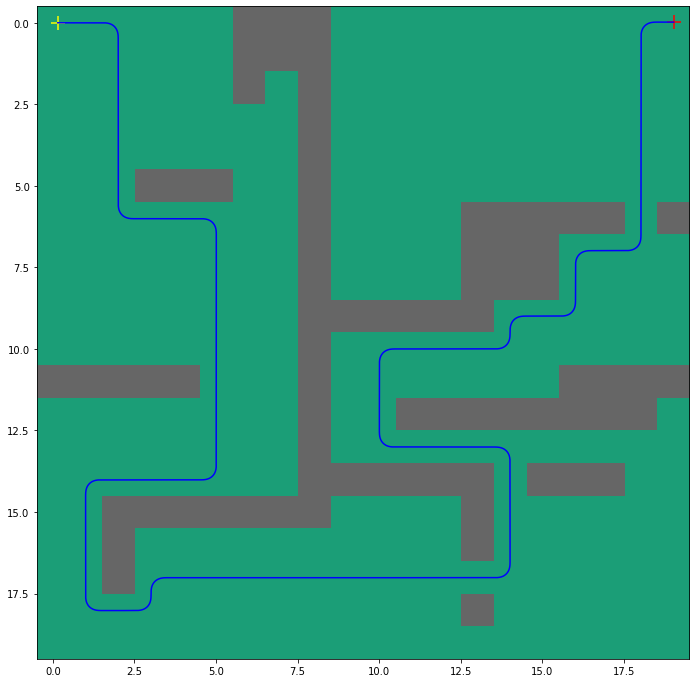

In [10]:
grid = np.load("astar_grid.npy")
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(grid, cmap=plt.cm.Dark2)
ax.scatter(ry[0],rx[0], marker = "+", color = "yellow", s = 200)
ax.scatter(ry[-1],rx[-1], marker = "+", color = "red", s = 200)
ax.plot(ry,rx,'blue')

In [218]:
class PurePursuitTracker(object):
    def __init__(self, x, y, v, lookahead = 3.0):
        """
        Tracks the path defined by x, y at velocity v
        x and y must be numpy arrays
        v and lookahead are floats
        """
        self.length = len(x)
        self.ref_idx = 0 #index on the path that tracker is to track
        self.lookahead = lookahead
        self.x, self.y = x, y
        self.v, self.w = v, 0

    def update(self, xc, yc, theta):
        """
        Input: xc, yc, theta - current pose of the robot
        Update v, w based on current pose
        Returns True if trajectory is over.
        """
        
        #Calculate ref_x, ref_y using current ref_idx
        #Check if we reached the end of path, then return TRUE
        #Two conditions must satisfy
        #1. ref_idx exceeds length of traj
        #2. ref_x, ref_y must be within goal_threshold
        # Write your code to check end condition
        ref_x, ref_y = self.x[self.ref_idx], self.y[self.ref_idx]
        goal_x, goal_y = self.x[-1], self.y[-1]
        if (self.ref_idx == self.length-1) and (np.linalg.norm([ref_x-goal_x, ref_y-goal_y])) < goal_threshold:
          return True
        
        #End of path has not been reached
        #update ref_idx using np.hypot([ref_x-xc, ref_y-yc]) < lookahead
        while np.hypot(ref_x-xc, ref_y-yc) < self.lookahead:
          self.ref_idx+= 1   
          ref_x, ref_y = self.x[self.ref_idx], self.y[self.ref_idx]    

        #Find the anchor point
        # this is the line we drew between (0, 0) and (x, y)
        anchor = np.asarray([ref_x - xc, ref_y - yc])
        #Remember right now this is drawn from current robot pose
        #we have to rotate the anchor to (0, 0, pi/2)
        #code is given below for this
        theta = np.pi/2 - theta
        rot = np.asarray([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        anchor = np.dot(rot, anchor)
        # print(anchor)

        L = np.sqrt(anchor[0] ** 2 + anchor[1] **2) # dist to reference path
        X = -anchor[0] #cross-track error
        #from the derivation in notes, plug in the formula for omega
        self.w = 2*self.v*X/(L**2)
        # print(self.w)
        
        return False

In [219]:
#write code to instantiate the tracker class
vmax = 0.1
goal_threshold = 0.05
lookahead = 1

def simulate_unicycle(pose, v,w, dt=0.1):
    x, y, t = pose
    return x + v*np.cos(t)*dt, y + v*np.sin(t)*dt, t+w*dt

tracker = PurePursuitTracker(rx,ry,vmax,lookahead) 
pose = (rx[0]+np.random.normal(0,0.1),ry[0]+np.random.normal(0,0.1),np.pi/2)
# pose = -1, 0, np.pi/2 #arbitrary initial pose
x0,y0,t0 = pose # record it for plotting
traj =[]
while True:
# for i in range(200):
    #write the usual code to obtain successive poses
    pose = simulate_unicycle(pose, tracker.v, tracker.w)
    xc,yc,tc = pose
    if tracker.update(xc,yc,tc) == True:
        print("ARRIVED!!")    
        break
    traj.append([*pose, tracker.w, tracker.ref_idx])

ARRIVED!!


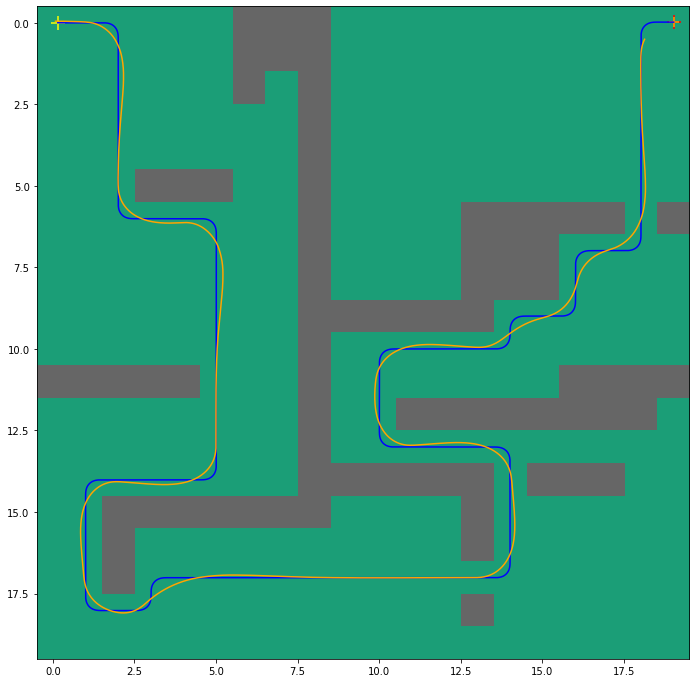

In [220]:
xs,ys,ts,deltas,ids = zip(*traj)
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(grid, cmap=plt.cm.Dark2)
ax.scatter(ry[0],rx[0], marker = "+", color = "yellow", s = 200)
ax.scatter(ry[-1],rx[-1], marker = "+", color = "red", s = 200)
ax.scatter(ry[ids[-1]],rx[ids[-1]],marker = "+",color = "orange", s = 100)
ax.plot(ry,rx,'blue')
ax.plot(ys,xs,'orange')

In [252]:
def simulate_bicycle(pose, v,delta, dt=0.1):
    x, y, t = pose
    return x + v*np.cos(t)*dt, y + v*np.sin(t)*dt, t+((v/0.9)*np.tan(delta)*dt)

class Stanley_tracker(object):
    def __init__(self, x, y, v, lookahead = 3.0):
        """
        Tracks the path defined by x, y at velocity v
        x and y must be numpy arrays
        v and lookahead are floats
        """
        self.length = len(x)
        self.ref_idx = 0 #index on the path that tracker is to track
        self.lookahead = lookahead
        self.x, self.y = x, y
        self.v, self.delta = v, 0
        self.k = 1/10

    def update(self, xc, yc, thetac):
        """
        Input: xc, yc, theta - current pose of the robot
        Update v, w based on current pose
        Returns True if trajectory is over.
        """
        
        #Calculate ref_x, ref_y using current ref_idx
        #Check if we reached the end of path, then return TRUE
        #Two conditions must satisfy
        #1. ref_idx exceeds length of traj
        #2. ref_x, ref_y must be within goal_threshold
        # Write your code to check end condition
        ref_x, ref_y = self.x[self.ref_idx], self.y[self.ref_idx]
        goal_x, goal_y = self.x[-1], self.y[-1]
        if (self.ref_idx == self.length-1) and (np.linalg.norm([ref_x-goal_x, ref_y-goal_y])) < goal_threshold:
          return True
        
        #End of path has not been reached
        #update ref_idx using np.hypot([ref_x-xc, ref_y-yc]) < lookahead
        while (np.hypot(ref_x-xc, ref_y-yc) < self.lookahead) and (self.ref_idx < self.length):
          self.ref_idx+= 1   
          ref_x, ref_y = self.x[self.ref_idx], self.y[self.ref_idx] 

        #Find the anchor point
        # this is the line we drew between (0, 0) and (x, y)
        anchor = np.asarray([ref_x - xc, ref_y - yc])
        #Remember right now this is drawn from current robot pose
        #we have to rotate the anchor to (0, 0, pi/2)
        #code is given below for this
        theta = np.pi/2 - thetac
        rot = np.asarray([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        anchor = np.dot(rot, anchor)
        # print(anchor)

        L = np.sqrt(anchor[0] ** 2 + anchor[1] **2) # dist to reference path
        X = -anchor[0] #cross-track error
        theta_path = np.arctan2((self.y[self.ref_idx-1] -ref_y),(self.x[self.ref_idx-1] -ref_x))
        # print(theta_path)
        theta_e = (theta_path - thetac)
        if theta_e > np.pi:
          theta_e -= 2.0 * np.pi
        if theta_e < -np.pi:
          theta_e += 2.0 * np.pi
        #from the derivation in notes, plug in the formula for omega
        # self.w = -2*self.v*X/(L**2)
        gain = self.k*2*0.9/L
        self.delta = (theta_e + np.arctan2(gain*X,self.v))
        # self.delta = theta_e
        
        return False

In [258]:
#write code to instantiate the tracker class
vmax = 0.3
goal_threshold = 0.05
lookahead = 0.8
tracker = Stanley_tracker(rx,ry,vmax,lookahead) 
pose = (rx[0]+np.random.normal(0,0.1),ry[0]+np.random.normal(0,0.1),np.pi/2)
# pose = -1, 0, np.pi/2 #arbitrary initial pose
x0,y0,t0 = pose # record it for plotting
traj =[]
while True:
# for i in range(2000):
    #write the usual code to obtain successive poses
    pose = simulate_bicycle(pose, tracker.v, tracker.delta)
    xc,yc,tc = pose
    if tracker.update(xc,yc,tc) == True:
        print("ARRIVED!!")    
        break
    traj.append([*pose, tracker.delta, tracker.ref_idx])

ARRIVED!!


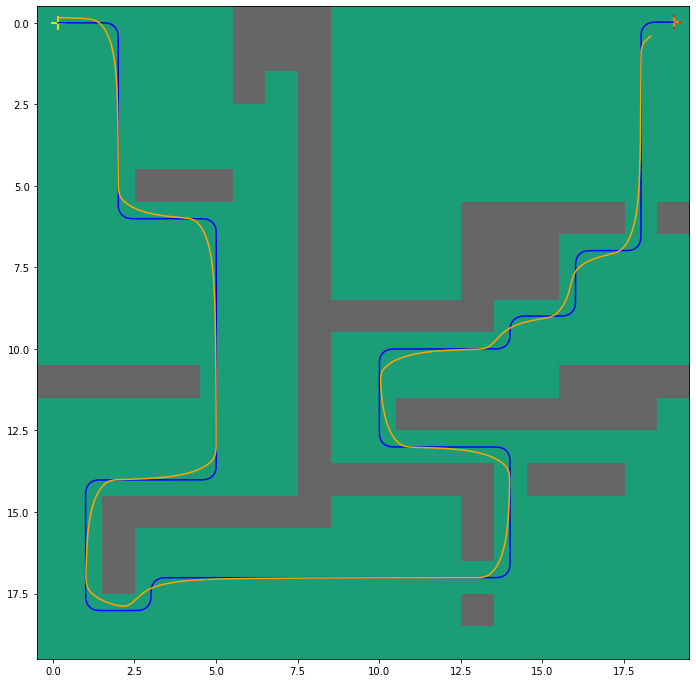

In [259]:
xs,ys,ts,deltas,ids = zip(*traj)
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(grid, cmap=plt.cm.Dark2)
ax.scatter(ry[0],rx[0], marker = "+", color = "yellow", s = 200)
ax.scatter(ry[-1],rx[-1], marker = "+", color = "red", s = 200)
ax.scatter(ry[ids[-1]],rx[ids[-1]],marker = "+",color = "orange", s = 100)
ax.plot(ry,rx,'blue')
ax.plot(ys,xs,'orange')